# Load neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import db_utils as dbu 

# Initiate database connection

In [2]:
dbname    = 'mapd'
username  = 'mapd'
password  = 'HyperInteractive'
hostname  = 'localhost'
port      = 9091

client = dbu.get_client(hostname, port, False)
session = client.connect(username, password, dbname)


# Get data into the GPU

It is expected the table `churn_telco_data` be in the database.
If not the run the following code:
```bash
!~/scripts/create_churn_table.sh
```

In [3]:
table_churn = "churn_telco_data"
query_churn = "SELECT * FROM {} ;".format(table_churn)
print('Query is : ' + query_churn)

tdf = client.sql_execute_gdf(session, query_churn, device_id=0, first_n=-1)

Query is : SELECT * FROM churn_telco_data ;


In [4]:
from pymapd._parsers import _parse_tdf_gpu
gdf = _parse_tdf_gpu(tdf)

Unfortunately at the moment it is not possible to use directly GPU dataframe for xgboost.

In [5]:
pd_df = gdf.to_pandas()
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,AK,71,510,332-2275,no,no,0,185.000000,84,31.450001,...,129,19.760000,191.100006,82,8.60,14.9,4,4.02,3,False.
1,DC,68,415,398-2138,yes,yes,39,142.000000,140,24.139999,...,89,20.540001,302.000000,72,13.59,11.3,5,3.05,1,False.
2,ID,104,415,357-1700,yes,no,0,148.199997,108,25.190001,...,113,13.750000,259.299988,103,11.67,11.0,4,2.97,0,False.
3,UT,100,408,370-9296,no,no,0,185.000000,122,31.450001,...,92,15.510000,274.899994,92,12.37,5.1,8,1.38,1,False.
4,IL,84,510,378-1303,no,no,0,181.500000,129,30.860001,...,112,11.110000,186.500000,118,8.39,8.5,4,2.30,1,False.


# Prepare data for xgboost
String columns have to be converted to numeric.


In [6]:

col_encoders = {}
for col in pd_df.columns[pd_df.dtypes == 'category']:
    label_encoder = LabelEncoder()
    col_encoders[col] = label_encoder.fit(pd_df[col])
    pd_df[col] = col_encoders[col].transform(pd_df[col])
    
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,0,71,510,155,0,0,0,185.000000,84,31.450001,...,129,19.760000,191.100006,82,8.60,14.9,4,4.02,3,0
1,7,68,415,2483,1,1,39,142.000000,140,24.139999,...,89,20.540001,302.000000,72,13.59,11.3,5,3.05,1,0
2,13,104,415,1082,1,0,0,148.199997,108,25.190001,...,113,13.750000,259.299988,103,11.67,11.0,4,2.97,0,0
3,44,100,408,1550,0,0,0,185.000000,122,31.450001,...,92,15.510000,274.899994,92,12.37,5.1,8,1.38,1,0
4,14,84,510,1778,0,0,0,181.500000,129,30.860001,...,112,11.110000,186.500000,118,8.39,8.5,4,2.30,1,0


## Remove unnecessary columns


In [7]:
y = pd_df['Churn'].values
del pd_df['Churn']
del pd_df['Phone']
#X = pd_df.values

# XGBoost

## Hyper-paramets

In [8]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['max_depth'] = 5
param['eta'] = 0.3
param['silent'] = 0
param['tree_method'] = 'gpu_exact'

num_round = 20

skf = StratifiedKFold(n_splits=5)

## Train

In [9]:
for i, (train, test) in enumerate(skf.split(pd_df, y)):
    dtrain = xgb.DMatrix(pd_df.iloc[train,:], label=y[train])
    tmp = time.time()
    bst = xgb.train(param, dtrain, num_round)
    boost_time = time.time() - tmp
    res = bst.eval(xgb.DMatrix(pd_df.iloc[test,:], label=y[test]))
    print("Fold {}: {}, Boost Time {}".format(i, res, str(boost_time)))
    #del bst

Fold 0: [0]	eval-auc:0.976778, Boost Time 0.13199567794799805
Fold 1: [0]	eval-auc:0.983565, Boost Time 0.10812759399414062
Fold 2: [0]	eval-auc:0.984649, Boost Time 0.1096498966217041
Fold 3: [0]	eval-auc:0.984408, Boost Time 0.11233019828796387
Fold 4: [0]	eval-auc:0.986667, Boost Time 0.10229849815368652


## Variable Importance

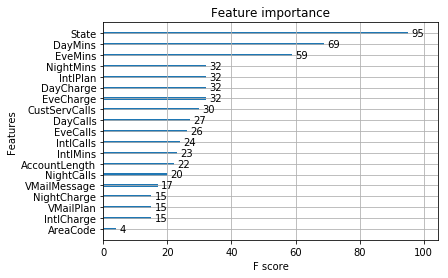

In [10]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(bst)
pyplot.show()

### Select top variable importance for grid creation

In [16]:
import operator
num_var = 8
varimp_dict = bst.get_fscore()
varimp = pd.DataFrame(sorted(varimp_dict.items(), key=operator.itemgetter(1), reverse=True))
varimp = varimp.iloc[0:num_var,]
varimp

,0,1
0,State,95
1,DayMins,69
2,EveMins,59
3,EveCharge,32
4,DayCharge,32
5,IntlPlan,32
6,NightMins,32
7,CustServCalls,30


In [24]:

iterCol = 'State' # iterCol is used to break the data into chunks (in case data does not fit in memory)
gridCols = varimp[0].tolist()
excols = list(set(pd_df.columns) - set(gridCols))
gridCols = list(set(gridCols) - set([iterCol]))

print("iterate column:", iterCol)
print("grid columns:", gridCols)
print("excluded columns:", excols)

iterate column: State
grid columns: ['EveMins', 'DayCharge', 'CustServCalls', 'IntlPlan', 'EveCharge', 'NightMins', 'DayMins']
excluded columns: ['IntlCharge', 'EveCalls', 'VMailMessage', 'IntlMins', 'AreaCode', 'DayCalls', 'VMailPlan', 'NightCalls', 'AccountLength', 'IntlCalls', 'NightCharge']


### Create partial dependence grid

In [26]:
from sklearn.ensemble.partial_dependence import _grid_from_X
import utils as ut

resolution = 10
df_grid = pd.DataFrame(ut._grid_from_X(pd_df[gridCols], grid_resolution=resolution)[0], columns=gridCols)
for col in excols:
    df_grid[col] = np.random.choice(pd_df[col].values, size=df_grid.shape[0], replace=True)

print("grid shape:", df_grid.shape)
df_grid.head(5)

EveMins
DayCharge
CustServCalls
IntlPlan
EveCharge
NightMins
DayMins
[  93.69999695  117.17777507  140.65555318  164.1333313   187.61110942
  211.08888753  234.56666565  258.04444377  281.52222188  305.        ]
hello:  10
[ 10.68999958  14.98777729  19.28555499  23.5833327   27.8811104
  32.17888811  36.47666581  40.77444352  45.07222123  49.36999893]
hello:  10
[3, 1, 0, 2, 4, 6, 9, 5, 7, 8]
hello:  10
[0, 1]
hello:  2
[  7.96000004   9.95666673  11.95333343  13.95000013  15.94666682
  17.94333352  19.94000022  21.93666691  23.93333361  25.93000031]
hello:  10
[  97.40000153  120.38888889  143.37777625  166.36666361  189.35555098
  212.34443834  235.3333257   258.32221307  281.31110043  304.29998779]
hello:  10
[  62.90000153   88.17777846  113.45555539  138.73333232  164.01110925
  189.28888618  214.56666311  239.84444004  265.12221697  290.3999939 ]
hello:  10
grid shape: (2000000, 18)


,EveMins,DayCharge,CustServCalls,IntlPlan,EveCharge,NightMins,DayMins,IntlCharge,EveCalls,VMailMessage,IntlMins,AreaCode,DayCalls,VMailPlan,NightCalls,AccountLength,IntlCalls,NightCharge
0,93.699997,10.69,3,0,7.96,97.400002,62.900002,0.00,74,31,6.6,510,99,1,77,41,7,10.69
1,93.699997,10.69,3,0,7.96,97.400002,88.177778,2.51,85,0,8.5,510,83,0,72,120,7,7.28
2,93.699997,10.69,3,0,7.96,97.400002,113.455555,3.21,118,0,8.3,408,108,0,102,73,4,10.81
3,93.699997,10.69,3,0,7.96,97.400002,138.733332,2.38,93,29,8.8,510,126,0,129,61,4,8.19
4,93.699997,10.69,3,0,7.96,97.400002,164.011109,3.62,98,0,10.7,510,68,0,57,151,3,11.48


### Calculate partial dependence predictions and save the results

In [27]:
!mkdir -p ./res

In [28]:
fmt=['%.3f', '%.3f', '%.3f', '%.3f', '%.3f', '%i', '%i', '%i', '%i', 
     '%i', '%.3f', '%i', '%i', '%i', '%.3f', '%.3f', '%.3f', '%i', '%i', '%s']

iterVals = pd_df[iterCol].unique()
bst.set_param({"predictor":"cpu_predictor"})
for v in iterVals:   
    t0 = time.time()
    print("State: ", v)
    
    # Set all state value to v
    df_grid[iterCol] = v
    t1 = time.time()
    
    #Predict
    pred_p1 = bst.predict(xgb.DMatrix(df_grid[pd_df.columns]))
    t2 = time.time()
    print("Time to pred: ", (t2-t1))
    
    #Concat prediction probs with predictors
    tmp_df = pd.concat([pd.DataFrame(pred_p1, columns=["p1"]), df_grid], axis=1)
    t3 = time.time()
    print("Time to concat: ", (t3-t2))
    
    # Decode state values
    tmp_df['State'] = col_encoders['State'].inverse_transform(tmp_df['State'])
    t4 = time.time()
    print("Time to encode state col: ", (t4-t3))
    
    # Save results
    fname = '../mein/res/df_state-{}.csv'.format(col_encoders['State'].inverse_transform(v))
    np.savetxt(fname, tmp_df.values, fmt=fmt, delimiter=',')
    t5 = time.time()
    print("Time to save results: ", (t5-t4))
    
    print("Time to loop:", (t5-t0))

State:  0
Time to pred:  1.6352877616882324
Time to concat:  0.07474064826965332
Time to encode state col:  0.062196969985961914
Time to save results:  17.5369291305542
Time to loop: 19.324949979782104
State:  7
Time to pred:  1.4655137062072754
Time to concat:  0.06311678886413574
Time to encode state col:  0.050547122955322266
Time to save results:  17.675214529037476
Time to loop: 19.266530752182007
State:  13
Time to pred:  1.4371798038482666
Time to concat:  0.06284236907958984
Time to encode state col:  0.05031704902648926
Time to save results:  17.797449588775635
Time to loop: 19.359875679016113
State:  44
Time to pred:  1.4700233936309814
Time to concat:  0.06377005577087402
Time to encode state col:  0.04965782165527344
Time to save results:  17.673732042312622
Time to loop: 19.27029538154602
State:  14
Time to pred:  1.4372832775115967
Time to concat:  0.06514191627502441
Time to encode state col:  0.050110578536987305
Time to save results:  17.868632793426514
Time to loop: 1

## Load the result into MapD database 

#### Create table for the results.

In [30]:
result_table_name = "churn_pd_results_2"
dbu.create_table_for(session, client, tmp_df, result_table_name)

Create query:  create table churn_pd_results_2 ( p1 FLOAT, EveMins FLOAT, DayCharge FLOAT, CustServCalls INT, IntlPlan INT, EveCharge FLOAT, NightMins FLOAT, DayMins FLOAT, IntlCharge FLOAT, EveCalls INT, VMailMessage INT, IntlMins FLOAT, AreaCode INT, DayCalls INT, VMailPlan INT, NightCalls INT, AccountLength INT, IntlCalls INT, NightCharge FLOAT, State TEXT ); 


TQueryResult(execution_time_ms=10, row_set=TRowSet(rows=[], is_columnar=False, columns=[], row_desc=[]), total_time_ms=19, nonce='')

#### Copy csv files into table:

In [31]:
wd = !pwd
copy_q = "COPY {} FROM '{}';".format(result_table_name, wd[0]+"/../mein/res/*")
client.sql_execute(session, copy_q, True, None, -1)

TQueryResult(execution_time_ms=549149, row_set=TRowSet(rows=[], is_columnar=True, columns=[TColumn(nulls=[False], data=TColumnData(str_col=['Loaded: 101999949 recs, Rejected: 0 recs in 547.064000 secs'], arr_col=[], int_col=[], real_col=[]))], row_desc=[TColumnType(src_name='', col_type=TTypeInfo(type=6, is_array=False, encoding=0, precision=0, comp_param=0, nullable=False, scale=0), is_reserved_keyword=False, col_name='Result')]), total_time_ms=549157, nonce='')